<a href="https://colab.research.google.com/github/afortuny/DeepLearningFastAI/blob/main/06_multicat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 30.6 MB/s 
     |████████████████████████████████| 4.2 MB 58.7 MB/s 
     |████████████████████████████████| 1.2 MB 57.9 MB/s 
     |████████████████████████████████| 197 kB 72.5 MB/s 
     |████████████████████████████████| 346 kB 66.7 MB/s 
     |████████████████████████████████| 60 kB 7.5 MB/s 
     |████████████████████████████████| 140 kB 73.0 MB/s 
     |████████████████████████████████| 212 kB 75.5 MB/s 
     |████████████████████████████████| 86 kB 8.3 MB/s 
     |████████████████████████████████| 86 kB 7.2 MB/s 
     |████████████████████████████████| 1.1 MB 62.6 MB/s 
     |████████████████████████████████| 596 kB 65.5 MB/s 
     |████████████████████████████████| 127 kB 65.6 MB/s 
     |████████████████████████████████| 144 kB 70.7 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
     |████████████████████████████████| 271 kB 71.6 MB/s 
     |████████████████████████████████| 112 kB 74.9 MB/s 
     |████████████████

In [2]:
#hide
from fastbook import *

## Multi-Label Classification

Multi-label classification refers to the problem of identifying the categories of objects in images that may not contain exactly one type of object. There may be more than one kind of object, or there may be no objects at all in the classes that you are looking for.

For instance, this would have been a great approach for any real classification problem when there may be no classes (such as the wildlife detector from driven data). This will avoid the fact of uploading an image with a totally new /no class and the algorithm being forced to provide one of the classes it has in its vocab. The multilabel classifier is even more general than the multiclass classifier, as it allows for the case where none of the expected labels are present in an image. One should therefore seriously consider it for production applications.

First, let's see what a multi-label dataset looks like, then we'll explain how to get it ready for our model. You'll see that the architecture of the model does not change from the last chapter; only the loss function does. Let's start with the data.

### The Data

For our example we are going to use the Amazon Planet dataset from the kaggle competition https://www.kaggle.com/datasets/nikitarom/planets-dataset. This is a real data set with satellite imaginery of the Amazonia, where we are expect to detect if in the area recorded there is agriculture, roads, clouds, rivers. This tasks is relevant to keep track of the evolution of the destruction of the Amazon to perform economic activities.

The following text summarizes the importance of the tasks for high definition imaginery data:

*Every minute, the world loses an area of forest the size of 48 football fields. And deforestation in the Amazon Basin accounts for the largest share, contributing to reduced biodiversity, habitat loss, climate change, and other devastating effects. But better data about the location of deforestation and human encroachment on forests can help governments and local stakeholders respond more quickly and effectively.*

*Planet, designer and builder of the world’s largest constellation of Earth-imaging satellites, will soon be collecting daily imagery of the entire land surface of the earth at 3-5 meter resolution. While considerable research has been devoted to tracking changes in forests, it typically depends on coarse-resolution imagery from Landsat (30 meter pixels) or MODIS (250 meter pixels). This limits its effectiveness in areas where small-scale deforestation or forest degradation dominate.*

*Furthermore, these existing methods generally cannot differentiate between human causes of forest loss and natural causes. Higher resolution imagery has already been shown to be exceptionally good at this, but robust methods have not yet been developed for Planet imagery.*

*In this competition, Planet and its Brazilian partner SCCON are challenging Kagglers to label satellite image chips with atmospheric conditions and various classes of land cover/land use. Resulting algorithms will help the global community better understand where, how, and why deforestation happens all over the world - and ultimately how to respond.*


We begin by downloading and extracting the dataset as per usual: *italicized text*

In [5]:
from fastai.vision.all import *
path = '/content/planet'

In [ ]:
#!unzip '/content/gdrive/MyDrive/Amazon/kaggle/planet/train_small.zip' -d '/content/gdrive/MyDrive/Amazon/kaggle/planet'

In [ ]:
#!unzip '/content/gdrive/MyDrive/Amazon/kaggle/planet/train-jpg.zip' -d '/content/gdrive/MyDrive/Amazon/kaggle/planet'

This dataset is different from the ones we have seen before, in that it is not structured by filename or folder but instead comes with a CSV (comma-separated values) file telling us what labels to use for each image. We can inspect the CSV file by reading it into a Pandas DataFrame:

For our example we are going to use the Amazon Planet dataset from the kaggle competition https://www.kaggle.com/datasets/nikitarom/planets-dataset. This is a real data set with satellite imaginery of the Amazonia, where we are expect to detect if in the area recorded there is agriculture, roads, clouds, rivers. This tasks is relevant to keep track of the evolution of the destruction of the Amazon to perform economic activities.

The following text summarizes the importance of the tasks for high definition imaginery data:

Every minute, the world loses an area of forest the size of 48 football fields. And deforestation in the Amazon Basin accounts for the largest share, contributing to reduced biodiversity, habitat loss, climate change, and other devastating effects. But better data about the location of deforestation and human encroachment on forests can help governments and local stakeholders respond more quickly and effectively.

Planet, designer and builder of the world’s largest constellation of Earth-imaging satellites, will soon be collecting daily imagery of the entire land surface of the earth at 3-5 meter resolution. While considerable research has been devoted to tracking changes in forests, it typically depends on coarse-resolution imagery from Landsat (30 meter pixels) or MODIS (250 meter pixels). This limits its effectiveness in areas where small-scale deforestation or forest degradation dominate.

Furthermore, these existing methods generally cannot differentiate between human causes of forest loss and natural causes. Higher resolution imagery has already been shown to be exceptionally good at this, but robust methods have not yet been developed for Planet imagery.

In this competition, Planet and its Brazilian partner SCCON are challenging Kagglers to label satellite image chips with atmospheric conditions and various classes of land cover/land use. Resulting algorithms will help the global community better understand where, how, and why deforestation happens all over the world - and ultimately how to respond.*



We begin by downloading and extracting the dataset as per usual:

As you can see, the list of categories in each image is shown as a space-delimited string.

In [106]:
df = pd.read_csv('/content/gdrive/MyDrive/Amazon/kaggle/planet/train_classes.csv')


In [107]:
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


We will add the jog ending in the file to have consistent images names with the format ending as in the train-jog folder

In [121]:
df.image_name	 = df.image_name + '.jpg'

In [122]:
df.head()

,image_name,tags
0,train_0.jpg,haze primary
1,train_1.jpg,agriculture clear primary water
2,train_2.jpg,clear primary
3,train_3.jpg,clear primary
4,train_4.jpg,agriculture clear habitation primary road


### Constructing a DataBlock

How do we convert from a `DataFrame` object to a `DataLoaders` object? We generally suggest using the data block API for creating a `DataLoaders` object, where possible, since it provides a good mix of flexibility and simplicity. Here we will show you the steps that we take to use the data blocks API to construct a `DataLoaders` object in practice, using this dataset as an example.

As we have seen, PyTorch and fastai have two main classes for representing and accessing a training set or validation set:

- `Dataset`:: A collection that returns a tuple of your independent and dependent variable for a single item
- `DataLoader`:: An iterator that provides a stream of mini-batches, where each mini-batch is a tuple of a batch of independent variables and a batch of dependent variables

On top of these, fastai provides two classes for bringing your training and validation sets together:

- `Datasets`:: An object that contains a training `Dataset` and a validation `Dataset`
- `DataLoaders`:: An object that contains a training `DataLoader` and a validation `DataLoader`

In the following, we use a condensed version of the DataBlock where we have two blocks : one for the images and another for multiple labels. We specify that we will get the images or our x variables from readying the first column of our dataframe df, and search for the file name in our train-jpg folder. Out y labels are in the second column of our dataframe df, and we separate all labels with the space delimiter. We use 10% for the validation seed and resize all images to 224 as it is common. We apply default transformations for that purpose.

In [80]:
import pathlib

In [ ]:
path = pathlib.Path('/content/gdrive/MyDrive/Amazon/kaggle/planet')
pascal = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, pref=path/"train-jpg"),
                   get_y=ColReader(1, label_delim=' '),
                   splitter=RandomSplitter(valid_pct=0.1, seed=42),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())
dls = pascal.dataloaders(df)


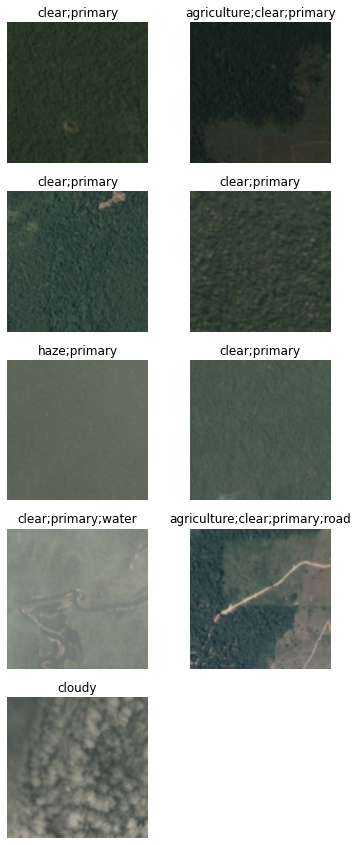

In [126]:
dls.show_batch(ncols=2)

In [125]:
?show_batch

To actually open the image and do the conversion to tensors, we will need to use a set of transforms; block types will provide us with those. We can use the same block types that we have used previously, with one exception: the `ImageBlock` will work fine again, because we have a path that points to a valid image, but the `CategoryBlock` is not going to work. The problem is that block returns a single integer, but we need to be able to have multiple labels for each item. To solve this, we use a `MultiCategoryBlock`. This type of block expects to receive a list of strings, as we have in this case, so let’s test it out:

As you can see, our list of categories is not encoded in the same way that it was for the regular `CategoryBlock`. In that case, we had a single integer representing which category was present, based on its location in our vocab. In this case, however, we instead have a list of zeros, with a one in any position where that category is present. For example, if there is a one in the second and fourth positions, then that means that vocab items two and four are present in this image. This is known as *one-hot encoding*. The reason we can’t easily just use a list of category indices is that each list would be a different length, and PyTorch requires tensors, where everything has to be the same length.

> jargon: One-hot encoding: Using a vector of zeros, with a one in each location that is represented in the data, to encode a list of integers.

Let’s check what the categories represent for this example (we are using the convenient `torch.where` function, which tells us all of the indices where our condition is true or false):

In [ ]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

With NumPy arrays, PyTorch tensors, and fastai’s `L` class, we can index directly using a list or vector, which makes a lot of code (such as this example) much clearer and more concise.

As we have discussed, a `DataLoader` collates the items from a `Dataset` into a mini-batch. This is a tuple of tensors, where each tensor simply stacks the items from that location in the `Dataset` item. 

Now that we have confirmed that the individual items look okay, there's one more step we need to ensure we can create our `DataLoaders`, which is to ensure that every item is of the same size. To do this, we can use `RandomResizedCrop`:

In [127]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, pref=path/"train-jpg"),
                   get_y=ColReader(1, label_delim=' '),
                   splitter=RandomSplitter(valid_pct=0.1, seed=42),
                   item_tfms=RandomResizedCrop(224, min_scale=0.35))
dls = dblock.dataloaders(df)

And now we can display a sample of our data:

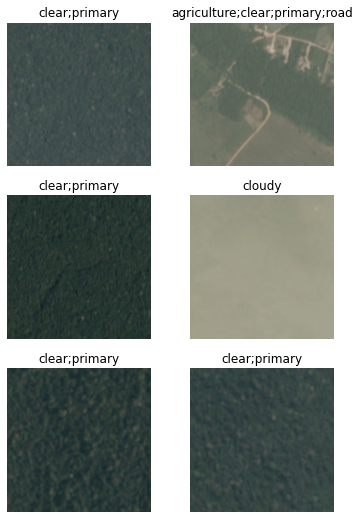

In [128]:
dls.show_batch(nrows=3, ncols=2)

Remember that if anything goes wrong when you create your `DataLoaders` from your `DataBlock`, or if you want to view exactly what happens with your `DataBlock`, you can use the `summary` method we presented in the last chapter.

Our data is now ready for training a model. As we will see, nothing is going to change when we create our `Learner`, but behind the scenes, the fastai library will pick a new loss function for us: binary cross-entropy.

### Binary Cross-Entropy

Now we'll create our `Learner`. We saw in <<chapter_mnist_basics>> that a `Learner` object contains four main things: the model, a `DataLoaders` object, an `Optimizer`, and the loss function to use. We already have our `DataLoaders`, we can leverage fastai's `resnet` models. So let's focus on ensuring we have a suitable loss function. To do this, let's use `vision_learner` to create a `Learner`, so we can look at its activations:

In [96]:
learn = vision_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

We also saw that the model in a `Learner` is generally an object of a class inheriting from `nn.Module`, and that we can call it using parentheses and it will return the activations of a model. You should pass it your independent variable, as a mini-batch. We can try it out by grabbing a mini batch from our `DataLoader` and then passing it to the model:

In [99]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 17])

Think about why `activs` has this shape—we have a batch size of 64, and we need to calculate the probability of each of 20 categories. Here’s what one of those activations looks like:

In [100]:
activs[0]

TensorBase([ 2.0206, -1.1447,  0.1851,  0.1841,  1.1640, -0.7109,  1.2065,  0.3307,  2.0438,  2.0154, -0.5387,  2.4433,  1.0371, -1.3505, -0.7189,  1.2696, -0.6335], grad_fn=<AliasBackward0>)

> note: Getting Model Activations: Knowing how to manually get a mini-batch and pass it into a model, and look at the activations and loss, is really important for debugging your model. It is also very helpful for learning, so that you can see exactly what is going on.

They aren’t yet scaled to between 0 and 1, but we learned how to do that using the `sigmoid` function. We also saw how to calculate a loss function with the addition of `log`

In [101]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

Note that because we have a one-hot-encoded dependent variable, we can't directly use `nll_loss` or `softmax` (and therefore we can't use `cross_entropy`):

- `softmax`, as we saw, requires that all predictions sum to 1, and tends to push one activation to be much larger than the others (due to the use of `exp`); however, we may well have multiple objects that we're confident appear in an image, so restricting the maximum sum of activations to 1 is not a good idea. By the same reasoning, we may want the sum to be *less* than 1, if we don't think *any* of the categories appear in an image.
- `nll_loss`, as we saw, returns the value of just one activation: the single activation corresponding with the single label for an item. This doesn't make sense when we have multiple labels.

On the other hand, the `binary_cross_entropy` function, which is just `mnist_loss` along with `log`, provides just what we need, thanks to the magic of PyTorch's elementwise operations. Each activation will be compared to each target for each column, so we don't have to do anything to make this function work for multiple columns.

PyTorch already provides this function for us. In fact, it provides a number of versions, with rather confusing names!

`F.binary_cross_entropy` and its module equivalent `nn.BCELoss` calculate cross-entropy on a one-hot-encoded target, but do not include the initial `sigmoid`. Normally for one-hot-encoded targets you'll want `F.binary_cross_entropy_with_logits` (or `nn.BCEWithLogitsLoss`), which do both sigmoid and binary cross-entropy in a single function, as in the preceding example.

The equivalent for single-label datasets (like MNIST or the Pet dataset), where the target is encoded as a single integer, is `F.nll_loss` or `nn.NLLLoss` for the version without the initial softmax, and `F.cross_entropy` or `nn.CrossEntropyLoss` for the version with the initial softmax.

Since we have a one-hot-encoded target, we will use `BCEWithLogitsLoss`:

In [102]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0292, grad_fn=<AliasBackward0>)

We don't actually need to tell fastai to use this loss function (although we can if we want) since it will be automatically chosen for us. fastai knows that the `DataLoaders` has multiple category labels, so it will use `nn.BCEWithLogitsLoss` by default.

One change compared to the last chapter is the metric we use: because this is a multilabel problem, we can't use the accuracy function. Why is that? Well, accuracy was comparing our outputs to our targets like so:

```python
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred = inp.argmax(dim=axis)
    return (pred == targ).float().mean()
```

The class predicted was the one with the highest activation (this is what `argmax` does). Here it doesn't work because we could have more than one prediction on a single image. After applying the sigmoid to our activations (to make them between 0 and 1), we need to decide which ones are 0s and which ones are 1s by picking a *threshold*. Each value above the threshold will be considered as a 1, and each value lower than the threshold will be considered a 0:

```python
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()
```

If we pass `accuracy_multi` directly as a metric, it will use the default value for `threshold`, which is 0.5. We might want to adjust that default and create a new version of `accuracy_multi` that has a different default. To help with this, there is a function in Python called `partial`. It allows us to *bind* a function with some arguments or keyword arguments, making a new version of that function that, whenever it is called, always includes those arguments.

We can now train our model. Let's try setting the accuracy threshold to 0.2 for our metric:

In [105]:
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.329050,0.175734,0.917720,06:51
1,0.137504,0.113046,0.943349,06:51
2,0.117250,0.103125,0.945951,06:50
3,0.109359,0.097603,0.953712,06:49


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.099813,0.101448,0.954787,09:21
1,0.092253,0.087971,0.956451,09:07
2,0.086605,0.086134,0.958413,09:01


Picking a threshold is important. If you pick a threshold that's too low, you'll often be failing to select correctly labeled objects. We can see this by changing our metric, and then calling `validate`, which returns the validation loss and metrics:

In [108]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.08613400906324387,0.9428551197052002]

If you pick a threshold that's too high, you'll only be selecting the objects for which your model is very confident:

In [109]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.08613400906324387,0.916164755821228]

We can find the best threshold by trying a few levels and seeing what works best. This is much faster if we just grab the predictions once:

In [110]:
preds,targs = learn.get_preds()

Then we can call the metric directly. Note that by default `get_preds` applies the output activation function (sigmoid, in this case) for us, so we'll need to tell `accuracy_multi` to not apply it:

In [111]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorBase(0.9508)

We can now use this approach to find the best threshold level:

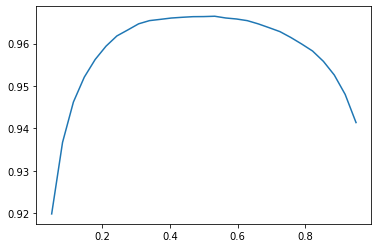

In [112]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In this case, we're using the validation set to pick a hyperparameter (the threshold), which is the purpose of the validation set. Sometimes students have expressed their concern that we might be *overfitting* to the validation set, since we're trying lots of values to see which is the best. However, as you see in the plot, changing the threshold in this case results in a smooth curve, so we're clearly not picking some inappropriate outlier. This is a good example of where you have to be careful of the difference between theory (don't try lots of hyperparameter values or you might overfit the validation set) versus practice (if the relationship is smooth, then it's fine to do this).

This concludes the part of this chapter dedicated to multi-label classification. Next, we'll take a look at a regression problem.

## Conclusion

In problems that are at first glance completely different (single-label classification, multi-label classification, and regression), we end up using the same model with just different numbers of outputs. The loss function is the one thing that changes, which is why it's important to double-check that you are using the right loss function for your problem.

fastai will automatically try to pick the right one from the data you built, but if you are using pure PyTorch to build your `DataLoader`s, make sure you think hard when you have to decide on your choice of loss function, and remember that you most probably want:

- `nn.CrossEntropyLoss` for single-label classification
- `nn.BCEWithLogitsLoss` for multi-label classification
- `nn.MSELoss` for regression